<a href="https://colab.research.google.com/github/OleKrarup123/NLSE-vector-solver/blob/main/SSFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##About this notebook!!!
This notebook shows a simple, scalar implementation of the [Split-Step Fourier Method](https://en.wikipedia.org/wiki/Split-step_method) for solving the [Nonlinear Schrodinger Equation](https://https://en.wikipedia.org/wiki/Nonlinear_Schr%C3%B6dinger_equation),

$\frac{\partial A}{\partial z}=-\frac{\alpha}{2}A-i \frac{\beta_2}{2} \frac{\partial^2 A}{\partial T^2}+i\gamma|A|^2A$.

This nonlinear partial differential equation models how the envelope and phase of light pulse changes when propagating through an optical fiber, when taking power attenuation ($\alpha$), Group Velocity Dispersion ($\beta_2$) and waveguide nonlinearity ($\gamma) causing Self-Phase Modulation (SPM) into account. 

If you are just starting your graduate studies in nonlinear optics, I encourage you to write your own implementation from scratch in a programming language of your choice as it's a great way to learn about the many exotic effects that can take place in optical fibers. 

This implementation contains a number of "TODO's" in the comments, which suggest features that a moderately experienced programmer should be able to implement without too much trouble. Consider downloading a copy of this notebook from my [GitHub page ](https://github.com/OleKrarup123/NLSE-vector-solver/blob/main/SSFM.ipynb), so you can play around with it on your own. 

If you want to learn more about experimental fiber optics, more than 20 tutorial videos are available on my [YouTube page](https://https://youtube.com/playlist?list=PLdFybGSAoPnnPkzL8zq6uR1yYZk4Ut_Zv). 


##Import useful libraries

In [70]:
import numpy as np
from scipy.fftpack import fft, ifft, fftshift, ifftshift, fftfreq

import matplotlib.pyplot as plt
global pi; pi=np.pi 

## Define simulation parameters


In [71]:
N  = 2**14 #Number of points
dt = 0.1e-12 #Time resolution [s] 



##Define function for getting FFT frequency range from time vector

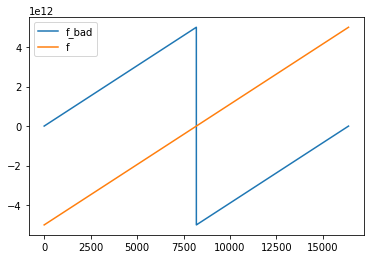

In [72]:
def getFreqRangeFromTime(time):
    return fftshift(fftfreq(len(time), d=time[1]-time[0]))


t=np.linspace(0,N*dt,N) #Time step array
t=t-np.mean(t)          #Center so middle entry is t=0

f_bad = fftfreq(len(t), d=t[1]-t[0]) 
f=getFreqRangeFromTime(t)



plt.figure()
plt.plot(f_bad,label="f_bad")
plt.plot(f,label="f")
plt.legend()
plt.show()

#NOTE: scipy is (for some reason) coded so the first entry is freq=0, the next 
#(N-1)/2 are all the positive frequencies and the remaining ones are the 
#negative ones. The function, fftshift, rearranges the entries so negative 
#frequencies come first

##Define class to hold simulation parameters

In [73]:
#Class for holding info about the simulation params
class SIM_config:
    def __init__(self,N,dt):
        self.number_of_points=N
        self.time_step=dt
        t=np.linspace(0,N*dt,N)
        self.t=t-np.mean(t)
        self.tmin=self.t[0]
        self.tmax=self.t[-1]
        
        self.f=getFreqRangeFromTime(self.t)
        self.fmin=self.f[0]
        self.fmax=self.f[-1]
        self.freq_step=self.f[1]-self.f[0]

        self.describe_config()
        
    def describe_config(self):
        print("### Configuration Parameters ###")
        print(f" Number of points = {self.number_of_points}")
        print(f" Start time, tmin = {self.tmin*1e12}ps")
        print(f" Stop time, tmax = {self.tmax*1e12}ps")
        print(f" Time resolution, dt = {self.time_step*1e12}ps")
        print("  ")
        print(f" Start frequency= {self.fmin/1e12}THz")
        print(f" Stop frequency = {self.fmax/1e12}THz")
        print(f" Frequency resolution= {self.freq_step/1e6}MHz")
        print( "   ")

#Initialize class
sim_config=SIM_config(N,dt)

### Configuration Parameters ###
 Number of points = 16384
 Start time, tmin = -819.2ps
 Stop time, tmax = 819.2ps
 Time resolution, dt = 0.1ps
  
 Start frequency= -4.999694824217917THz
 Stop frequency = 4.99908450990832THz
 Frequency resolution= 610.3143095966797MHz
   


##Functions for creating a Gaussian pulse to be simulated

In [74]:
#Function returns pulse power or spectrum PSD
def getPower(amplitude):
    return np.abs(amplitude)**2  

#Function gets the energy of a pulse pulse or spectrum by integrating the power
def getEnergy(time_or_frequency,amplitude):
    return np.trapz(getPower(amplitude),time_or_frequency)

#TODO: Add support for different carrier frequencies. Hint: Multiply by complex exponential!
#TODO: Add support for pre-chirped pulses. 
def GaussianPulse(time,amplitude,duration,offset):
    return amplitude*np.exp(- ((time-offset)/(duration))**2/2)*(1+0j)

##Test functions:

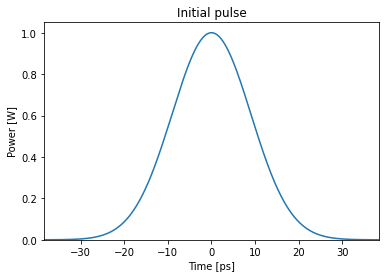

In [75]:


#Initialize Gaussian pulse
amplitude = 1                       #Amplitude in units of sqrt(W)
duration  = 2**7*sim_config.time_step   #Pulse 1/e^2 duration [s]
offset    = 0                       #Time offset

testPulse=GaussianPulse(t, amplitude, duration, offset)

plt.figure()
plt.title("Initial pulse")
plt.plot(sim_config.t*1e12,getPower(testPulse))
plt.axis([-duration*3*1e12,duration*3*1e12,0,1.05*amplitude**2])
plt.xlabel("Time [ps]")
plt.ylabel("Power [W]")
plt.show()

##Function for getting the spectrum corresponding to a given pulse

In [76]:
def getSpectrumFromPulse(time,pulse_amplitude):
    pulseEnergy=getEnergy(time,pulse_amplitude) #Get pulse energy
    f=getFreqRangeFromTime(time) 
    dt=time[1]-time[0]
    
    spectrum_amplitude=fftshift(fft(pulse_amplitude))*dt #Take FFT and do shift
    spectrumEnergy=getEnergy(f, spectrum_amplitude) #Get spectrum energy
    
    err=np.abs((pulseEnergy/spectrumEnergy-1))
    
    assert( err<1e-7 ), f'ERROR = {err}: Energy changed when going from Pulse to Spectrum!!!' 
    
    return spectrum_amplitude



#Equivalent function for getting time base from frequency range
def getTimeFromFrequency(frequency):  
    return fftshift(fftfreq(len(frequency), d=frequency[1]-frequency[0]))


#Equivalent function for getting pulse from spectrum
def getPulseFromSpectrum(frequency,spectrum_amplitude):
    
    spectrumEnergy=getEnergy(frequency, spectrum_amplitude)
    
    time = getTimeFromFrequency(frequency)
    dt = time[1]-time[0]
     
    pulse = ifft(ifftshift(spectrum_amplitude))/dt
    pulseEnergy = getEnergy(time, pulse)
    
    err=np.abs((pulseEnergy/spectrumEnergy-1))

    assert( err<1e-7   ), f'ERROR = {err}: Energy changed when going from Spectrum to Pulse!!!' 
    
    return pulse

#Equivalent function for generating a Gaussian spectrum
def GaussianSpectrum(frequency,amplitude,bandwidth):
    time = getTimeFromFrequency(frequency)
    return getSpectrumFromPulse(time, GaussianPulse(time, amplitude, 1/bandwidth, 0))

##Test functions

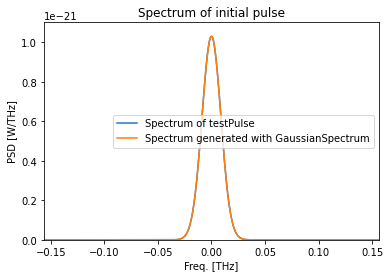

In [77]:

testSpectrum=getSpectrumFromPulse(sim_config.t,testPulse)
testSpectrum_2=GaussianSpectrum(sim_config.f,amplitude,1/duration)


plt.figure()
plt.title("Spectrum of initial pulse")
plt.plot(sim_config.f/1e12,getPower(testSpectrum),label="Spectrum of testPulse")
plt.plot(sim_config.f/1e12,getPower(testSpectrum_2),label="Spectrum generated with GaussianSpectrum")
plt.axis([-1/duration*2/1e12,1/duration*2/1e12,0,1.1e-21])
plt.xlabel("Freq. [THz]")
plt.ylabel("PSD [W/THz]")
plt.legend()
plt.show()




##Set up properties of the fiber

In [78]:
#Class for holding info about the fiber
class Fiber_config:
  def __init__(self,nsteps,L,gamma,beta2,alpha_dB_per_m):
      self.nsteps=nsteps
      self.Length=L
      self.dz=L/nsteps
      self.gamma=gamma
      self.beta2=beta2
      self.alpha_dB_per_m=alpha_dB_per_m
      self.alpha_Np_per_m = self.alpha_dB_per_m*np.log(10)/10.0 #Loss coeff is usually specified in dB/km, but Nepers/km is more useful for calculations
      #TODO: Make alpha frequency dependent.  
  
#Define fiberulation parameters
Length          = 1e3      #Fiber length in m
nsteps          = 2**8     #Number of steps we divide the fiber into

gamma           = 10e-3     #Nonlinearity parameter in 1/W/m 
beta2           = 100e3    #Dispersion in fs^2/m (units typically used when referring to beta2) 
beta2          *= (1e-30)  #Convert fs^2 to s^2 so everything is in SI units
alpha_dB_per_m  = 0.2e-3   #Power attenuation coeff in decibel per m. Usual value at 1550nm is 0.2 dB/km

#Note:  beta2>0 is normal dispersion with red light pulling ahead, 
#       causing a negative leading chirp
#       
#       beta2<0 is anormalous dispersion with blue light pulling ahead, 
#       causing a positive leading chirp.

  
#  Initialize class
fiber=Fiber_config(nsteps, Length, gamma, beta2, alpha_dB_per_m)





##Define SSFM function

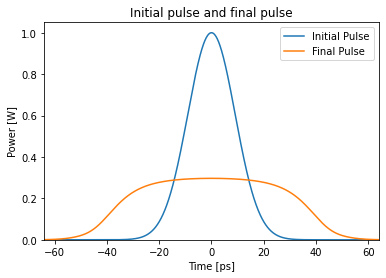

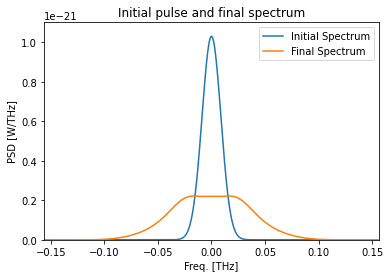

In [79]:
#TODO: Rewrite SSFM so it returns a matrix containing the pulse amplitude for each step and same for spectrum
def SSFM(fiber:Fiber_config,sim:SIM_config, pulse):
    #Pre-calculate effect of dispersion and loss as it's the same everywhere
    disp_and_loss=np.exp((1j*fiber.beta2/2*(2*pi*sim.f)**2-fiber.alpha_Np_per_m/2)*fiber.dz )
    
    #Precalculate constants for nonlinearity
    nonlinearity=1j*fiber.gamma*fiber.dz
    
    for n in range(fiber.nsteps):   
        pulse*=np.exp(nonlinearity*getPower(pulse)) #Apply nonlinearity
        dummySpectrum = getSpectrumFromPulse(sim.t, pulse)*disp_and_loss #Go to spectral domain and apply disp and loss
        pulse=getPulseFromSpectrum(sim.f, dummySpectrum) #Return to time domain and repeat
        
    
    return pulse,dummySpectrum 

#Initial pulse and spectrum
testPulse0=np.copy(testPulse)
testSpectrum0=np.copy(testSpectrum)

#Run SSFM
finalPulse, finalSpectrum=SSFM(fiber,sim_config,testPulse)

#Plot results and compare with input
plt.figure()
plt.title("Initial pulse and final pulse")
plt.plot(sim_config.t*1e12,getPower(testPulse0),label="Initial Pulse")
plt.plot(sim_config.t*1e12,getPower(finalPulse),label="Final Pulse")
plt.axis([-duration*5*1e12,duration*5*1e12,0,1.05*amplitude**2])
plt.xlabel("Time [ps]")
plt.ylabel("Power [W]")
plt.legend()
plt.show()

plt.figure()
plt.title("Initial pulse and final spectrum")
plt.plot(sim_config.f/1e12,getPower(testSpectrum0),label="Initial Spectrum")
plt.plot(sim_config.f/1e12,getPower(finalSpectrum),label="Final Spectrum")
plt.axis([-1/duration*2/1e12,1/duration*2/1e12,0,1.1e-21])
plt.xlabel("Freq. [THz]")
plt.ylabel("PSD [W/THz]")
plt.legend()
plt.show()



^We get interesting pulse and spectrum shapes out, but are we sure that loss, dispersion and nonlinearity have been applied correctly?

##Test that effect of loss calculated with SSFM matches theoretical prediction.

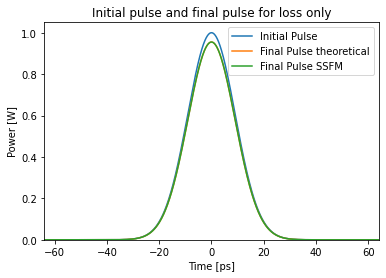

Loss error computed by energy of difference between theory and SSFM is 0.0008808798301462557
Loss error computed by difference of energy between theory and SSFM is 8.336567740309426e-14


In [80]:
#Define new fiber with only loss
fiber_loss_only=Fiber_config(fiber.nsteps, fiber.Length, 0, 0, fiber.alpha_dB_per_m)

#Apply theoretical effect of loss only
finalPulse_loss_only_theoretical = np.copy(testPulse0)*np.exp(-fiber.alpha_Np_per_m/2*fiber.Length)

#Calculate effect of loss only numerically
finalPulse_loss_only_SSFM, _ = SSFM(fiber_loss_only,sim_config,testPulse)


#Do the orange and green curves match?
plt.figure()
plt.title("Initial pulse and final pulse for loss only")
plt.plot(sim_config.t*1e12,getPower(testPulse0),label="Initial Pulse")
plt.plot(sim_config.t*1e12,getPower(finalPulse_loss_only_theoretical),label="Final Pulse theoretical")
plt.plot(sim_config.t*1e12,getPower(finalPulse_loss_only_SSFM),label="Final Pulse SSFM")
plt.axis([-duration*5*1e12,duration*5*1e12,0,1.05*amplitude**2])
plt.xlabel("Time [ps]")
plt.ylabel("Power [W]")
plt.legend()
plt.show()

#Quantify error by looking at the energy of the difference between numerical and theoretical result. 
loss_err = getEnergy(sim_config.t,(finalPulse_loss_only_SSFM-finalPulse_loss_only_theoretical))/getEnergy(sim_config.t, finalPulse_loss_only_theoretical)
print(f"Loss error computed by energy of difference between theory and SSFM is {loss_err}")


#Alternatively, compute the difference of their two energies
loss_err2 = (getEnergy(sim_config.t,finalPulse_loss_only_SSFM)-getEnergy(sim_config.t,finalPulse_loss_only_theoretical))/getEnergy(sim_config.t, finalPulse_loss_only_theoretical)
print(f"Loss error computed by difference of energy between theory and SSFM is {loss_err2}")


##Test that the effect of dispersion calculated by SSFM matches result from theory

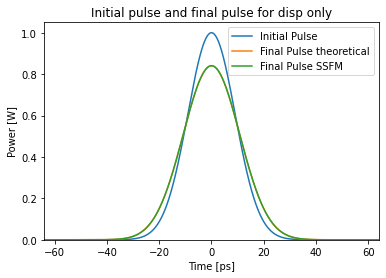

Disp error computed by energy of difference between theory and SSFM is 2.862581646240018e-27
Disp error computed by difference of energy between theory and SSFM is 8.588014869536971e-14


In [81]:
#Define new fiber with only dispersion
fiber_disp_only=Fiber_config(fiber.nsteps, fiber.Length, 0, fiber.beta2, 0)

#Apply theoretical effect of only dispersion
disp_theo = np.exp(1j*fiber_disp_only.beta2/2*(2*pi*sim_config.f)**2*fiber_disp_only.Length )  
finalPulse_disp_only_theo = getPulseFromSpectrum(sim_config.f, getSpectrumFromPulse(sim_config.t,testPulse)*disp_theo)

#Calculate disperson only effect numerically
finalPulse_disp_only_SSFM, _ = SSFM(fiber_disp_only,sim_config,testPulse)


#Do the orange and green curves match?
plt.figure()
plt.title("Initial pulse and final pulse for disp only")
plt.plot(sim_config.t*1e12,getPower(testPulse0),label="Initial Pulse")
plt.plot(sim_config.t*1e12,getPower(finalPulse_disp_only_theo),label="Final Pulse theoretical")
plt.plot(sim_config.t*1e12,getPower(finalPulse_disp_only_SSFM),label="Final Pulse SSFM")
plt.axis([-duration*5*1e12,duration*5*1e12,0,1.05*amplitude**2])
plt.xlabel("Time [ps]")
plt.ylabel("Power [W]")
plt.legend()
plt.show()

#Quantify error by looking at the energy of the difference between numerical and theoretical result. 
disp_err = getEnergy(sim_config.t,(finalPulse_disp_only_SSFM-finalPulse_disp_only_theo))/getEnergy(sim_config.t, finalPulse_disp_only_theo)
print(f"Disp error computed by energy of difference between theory and SSFM is {disp_err}")


#Alternatively, compute the difference of their two energies
disp_err2 = (getEnergy(sim_config.t,finalPulse_disp_only_SSFM)-getEnergy(sim_config.t,finalPulse_disp_only_theo))/getEnergy(sim_config.t, finalPulse_disp_only_theo)
print(f"Disp error computed by difference of energy between theory and SSFM is {disp_err2}")

Positive dispersion (beta2>0) should lead to a negative (red) frequency shift (chirp) for the leading part of the pulse. Let's check that this is correct.

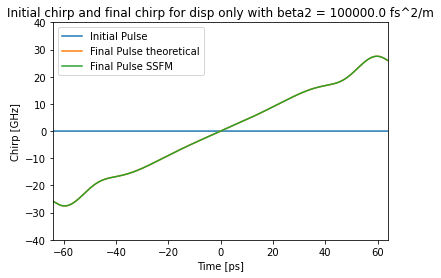

In [82]:
def getPhase(pulse):
    phi=np.unwrap(np.angle(pulse)) #Get phase starting from 1st entry
    phi=phi-phi[int(len(phi)/2)]   #Center phase on middle entry
    return phi    


def getChirp(time,pulse):
    phi=getPhase(pulse)
    dphi=np.diff(phi ,prepend = phi[0] - (phi[1]  - phi[0]  )) #Change in phase. Prepend to ensure consistent array size 
    dt  =np.diff(time,prepend = time[0]- (time[1] - time[0] )) #Change in time.  Prepend to ensure consistent array size

    chirp = -1.0/(2*pi)*dphi/dt #Chirp = - 1/(2pi) * d(phi)/dt

    
    return chirp

#Is the chirp negative (red) in the front and positive (blue) in the back for beta2>0? 
#Is the chirp positive (blue) in the front and negative (red) in the back for beta2<0? 

plt.figure()
plt.title(f"Initial chirp and final chirp for disp only with beta2 = {fiber.beta2*1e30} fs^2/m")
plt.plot(sim_config.t*1e12,getChirp(sim_config.t,testPulse0)/1e9,label="Initial Pulse")
plt.plot(sim_config.t*1e12,getChirp(sim_config.t,finalPulse_disp_only_theo)/1e9,label="Final Pulse theoretical")
plt.plot(sim_config.t*1e12,getChirp(sim_config.t,finalPulse_disp_only_SSFM)/1e9,label="Final Pulse SSFM")
plt.axis([-duration*5*1e12,duration*5*1e12,-40,40])
plt.xlabel("Time [ps]")
plt.ylabel("Chirp [GHz]")
plt.legend()
plt.show() 



##Test that effect of $\gamma$ only matches theoretical prediction

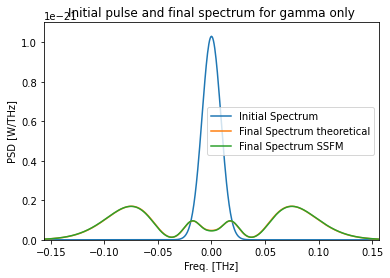

Gamma error computed by energy of difference between theory and SSFM is 0.0008808798301654075
Gamma error computed by difference of energy between theory and SSFM is 8.616499164293538e-14


In [83]:
#Define new fiber with only gamma
fiber_gamma_only=Fiber_config(fiber.nsteps, fiber.Length, fiber.gamma, 0, 0)

#Apply theoretical effect of only gamma
finalPulse_gamma_only_theoretical = np.copy(testPulse0)*np.exp(1j*(fiber_gamma_only.Length)*(fiber_gamma_only.gamma)*getPower(testPulse0))


finalSpectrum_gamma_only_theoretical=getSpectrumFromPulse(sim_config.t,finalPulse_gamma_only_theoretical)


#Calculate disperson only effect numerically
_, finalSpectrum_gamma_only_SSFM = SSFM(fiber_gamma_only,sim_config,testPulse)


#Do the orange and green curves match?
plt.figure()
plt.title("Initial pulse and final spectrum for gamma only")
plt.plot(sim_config.f/1e12,getPower(testSpectrum0),label="Initial Spectrum")
plt.plot(sim_config.f/1e12,getPower(finalSpectrum_gamma_only_theoretical),label="Final Spectrum theoretical")
plt.plot(sim_config.f/1e12,getPower(finalSpectrum_gamma_only_SSFM),label="Final Spectrum SSFM")
plt.axis([-1/duration*2/1e12,1/duration*2/1e12,0,1.1e-21])
plt.xlabel("Freq. [THz]")
plt.ylabel("PSD [W/THz]")
plt.legend()
plt.show()

#Quantify error by looking at the energy of the difference between numerical and theoretical result. 
gamma_err = getEnergy(sim_config.f,(finalSpectrum_gamma_only_SSFM-finalSpectrum_gamma_only_theoretical))/getEnergy(sim_config.f, finalSpectrum_gamma_only_theoretical)
print(f"Gamma error computed by energy of difference between theory and SSFM is {gamma_err}")


#Alternatively, compute the difference of their two energies
gamma_err2 = (getEnergy(sim_config.f,finalSpectrum_gamma_only_SSFM)-getEnergy(sim_config.f,finalSpectrum_gamma_only_theoretical))/getEnergy(sim_config.f, finalSpectrum_gamma_only_theoretical)
print(f"Gamma error computed by difference of energy between theory and SSFM is {gamma_err2}")

##Let's also check if SPM causes a negative (red) leading chirp

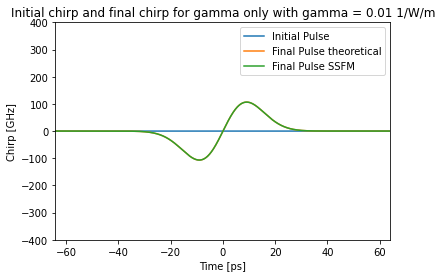

In [84]:
#Is the chirp negative (red) in the front and positive (blue) in the back for gamma>0? 
#Is the chirp positive (blue) in the front and negative (red) in the back for gamma<0? 
plt.figure()
plt.title(f"Initial chirp and final chirp for gamma only with gamma = {fiber_gamma_only.gamma} 1/W/m")
plt.plot(sim_config.t*1e12,getChirp(sim_config.t,testPulse0)/1e9,label="Initial Pulse")
plt.plot(sim_config.t*1e12,getChirp(sim_config.t,finalPulse_gamma_only_theoretical)/1e9,label="Final Pulse theoretical")
plt.plot(sim_config.t*1e12,getChirp(sim_config.t,finalPulse_gamma_only_theoretical)/1e9,label="Final Pulse SSFM")
plt.axis([-duration*5*1e12,duration*5*1e12,-400,400])
plt.xlabel("Time [ps]")
plt.ylabel("Chirp [GHz]")
plt.legend()
plt.show() 

Let's try to simulate the same pulse used in my video demonstrating SPM experimentally, https://youtu.be/wZyaTVTmmBk. Below is a picture of the fiber we used. The Chromatic Dispersion Parameter, $D_c$, can be converted to $\beta_2$ using the tool on this page: https://www.rp-photonics.com/chromatic_dispersion.html.

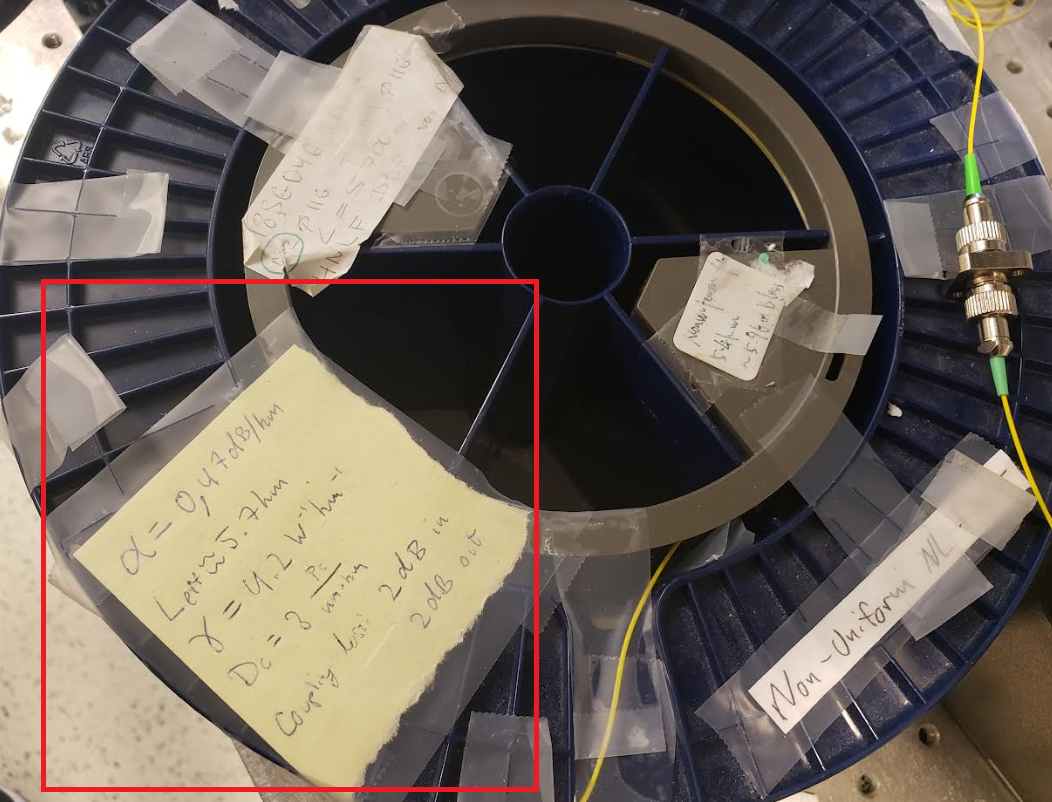

Below is the laser source we used

(Picture of laser source)

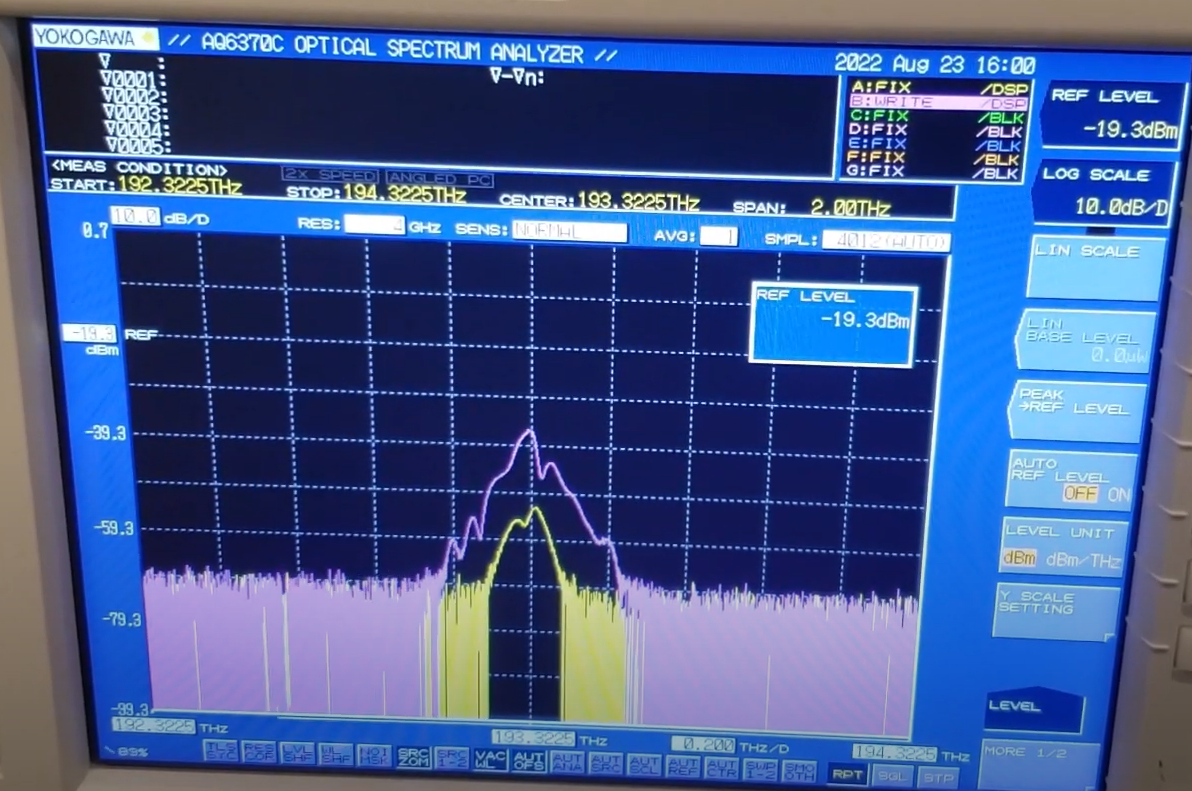

^From the OSA recording, we see that the 10dB width of the initial pulse spectrum (yellow) is around **100GHz**. The 10dB width of the final specturm at the end of the fiber is **150GHz**. The ratio of these two values is roughly **3/2 = 1.5**. Keep this number in mind for later!


In [85]:

#Fiber used in SPM experiment
L_exp      = 5.7e3 #m
gamma_exp  = 4.2e-3 #1/W/m
beta2_exp  = -3.83e3 #fs^2/m
beta2_exp *= 1e-30 #convert to s^2/m
alpha_exp  = 0.47e-3# dB/m, 

fiber_from_SPM_experiment=Fiber_config(fiber.nsteps,L_exp,gamma_exp,beta2_exp ,alpha_exp)

expAmplitude=np.sqrt(20) #sqrt(W)
expDuration=10e-12 #Duration in ps

#TODO: Include these values in fiber_config with defaults being 0 if unspecified
inputLoss=2 #dB of power
outputLoss=2 #dB of power

voaAttenuation=16 #The variable optical attenuator was set to 16dB in the experiment

#Get Gaussian pulse and apply input loss and VOA attenuation
expPulse=GaussianPulse(sim_config.t,expAmplitude,expDuration,0)*10**( -inputLoss/10/2 ) *10**( -voaAttenuation/10/2 )
expSpectrum=getSpectrumFromPulse(sim_config.t,expPulse)

#Propagate through fiber
expPulseFinal, expSpectrumFinal = SSFM(fiber_from_SPM_experiment,sim_config,expPulse)

#Apply output loss
expPulseFinal    *= 10**( -outputLoss/10/2 )
expSpectrumFinal *= 10**( -outputLoss/10/2 )





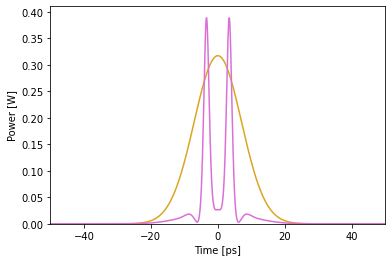

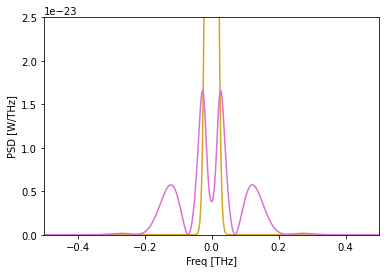

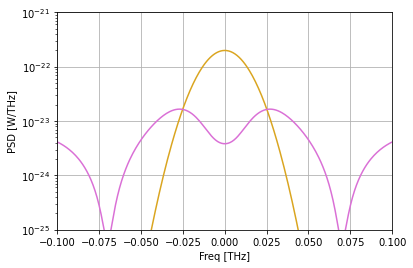

In [86]:
#Plot results
plt.figure()
plt.plot(sim_config.t*1e12,getPower(expPulse),'goldenrod')
plt.plot(sim_config.t*1e12,getPower(expPulseFinal),'orchid')
plt.axis([-expDuration*5*1e12,expDuration*5*1e12,0,2.05*expAmplitude**2*10**( -inputLoss/10*2 ) *10**( -voaAttenuation/10 )])
plt.xlabel('Time [ps]')
plt.ylabel('Power [W]')
plt.show()

plt.figure()
plt.plot(sim_config.f/1e12,getPower(expSpectrum),'goldenrod')
plt.plot(sim_config.f/1e12,getPower(expSpectrumFinal),'orchid')
plt.xlabel('Freq [THz]')
plt.ylabel('PSD [W/THz]')
plt.axis([-1/expDuration*5/1e12,1/expDuration*5/1e12,0,0.25e-22])
plt.show()

plt.figure()
plt.plot(sim_config.f/1e12,getPower(expSpectrum),'goldenrod')
plt.plot(sim_config.f/1e12,getPower(expSpectrumFinal),'orchid')
plt.xlabel('Freq [THz]')
plt.ylabel('PSD [W/THz]')
plt.yscale('log')
plt.grid()
plt.axis([-1/expDuration*1/1e12,1/expDuration*1/1e12,1e-25,1e-21])
plt.show()

The 10dB width of the initial spectrum used for the simulation is around **50GHz**, while the 10dB width of the final spectrum is around **120GHZ**, which is a ratio of around 2.4. These values do not match the experimental ones exactly. One reason may be that the pulse launched in the experiment had already experienced a bit of SPM before entering the fiber as can be seen from the "dual peaks" of the yellow input trace. Thus its initial spectrum is wider than the spectrum of the "clean" gaussian pulse used for the simulation.

##Check how reducing the number of steps affects pulse accuracy

According to [theoretical considerations](https://en.wikipedia.org/wiki/Split-step_method), the error should decrease according to (Δz)^2. Let's check if this is the case by



1.   Using the pulse computed with nsteps as a baseline 
2.   Running SSFM with increasing step numbers (=decreasing step size) and determining the error between the calculated pulse and the baseline
3. Plotting the error as a function of nsteps, fitting a model like "b*(nsteps)^a" to the data and checking if a=-2. 



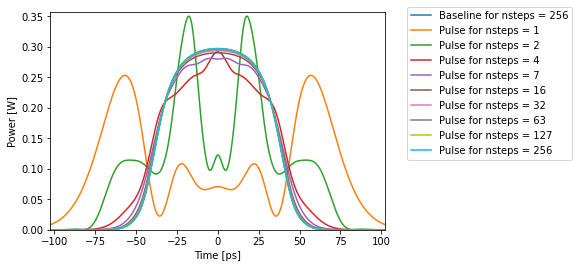

In [87]:

#First, make a copy of the pulse computed with the original fiber settings and nsteps
baselinePulse = np.copy(finalPulse)

#Make array of the number of steps
nsteps_list=np.logspace(0,np.log10(fiber.nsteps),9)  

#Pre-define arrays for holding errors
err_list=np.zeros_like(nsteps_list)*1.0


#Start figure and plot the pulse with the large number of steps
plt.figure()
plt.plot(sim_config.t*1e12,getPower(baselinePulse),label=f"Baseline for nsteps = {fiber.nsteps}")

#For each iteration, define a new fiber with a different number of steps but the same physical properties
for i in range(0,len(nsteps_list)):
  nsteps_i=int(nsteps_list[i])
  fiber_i=Fiber_config(nsteps_i, fiber.Length, fiber.gamma, fiber.beta2, fiber.alpha_dB_per_m)
  
  #Run the simulation and plot the computed pulse
  pulse_i,_=SSFM(fiber_i,sim_config,np.copy(testPulse0))
  
  plt.plot(sim_config.t*1e12,getPower(pulse_i),label=f"Pulse for nsteps = {nsteps_i}")
  
  #Compute and store errors
  err = getEnergy(sim_config.t,(pulse_i-baselinePulse))/getEnergy(sim_config.t, baselinePulse)*100
  err_list[i]=err


plt.xlabel("Time [ps]")
plt.ylabel("Power [W]")
plt.axis([-duration*8*1e12,duration*8*1e12,0,1.2*np.max(getPower(baselinePulse))])
plt.legend(bbox_to_anchor=(1.05,0.3))
plt.show()







Now make a plot of the error versus nsteps

Model parameters [a,b]= [-2.104655    0.20203822]


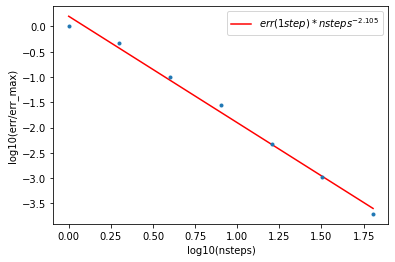

In [88]:
x=np.log10(nsteps_list[0:-2])
y=np.log10(err_list[0:-2]/np.max(err_list))

model = np.polyfit(x, y, 1)
print("Model parameters [a,b]=",model)
y_model=np.poly1d(model)
plt.figure()
plt.plot(x,y_model(x),'r-',label=f"$err(1 step)*nsteps^{  {np.round(model[0],3)}}$")
plt.plot(x,y,'.')
plt.xlabel('log10(nsteps)')
plt.ylabel('log10(err/err_max)')
plt.legend()
plt.show()


##Things to investigate!



1.   How does the runtime change when you alter N (number of time divisions)?
2.   Can you implement [3rd order dispersion](https://www.rp-photonics.com/third_order_dispersion.html) as well?
3.   How does the maximum chirp from dispersion change as a function of |$\beta_2$|?
4.   How does the maximum chirp from SPM change as a function of $\gamma$?
5.   Can you find a negative value of $\beta_2$ that cancels out the chirp created by $\gamma$? 




